### Wilson (Wil) Sheffield  
### May 6, 2025  
### Sentiment Analysis vs. Star Ratings in User Reviews Across Media, Apps, and Products

---

## Brief Abstract

This project examines the correlation of user-generated star ratings and sentiment in written reviews of three consumer markets: film, mobile applications, and e-commerce items. In order to include a variety of opinions, data was obtained from three differing sources: web-scraped reviews at Letterboxd (films), API-retrieved reviews at the Google Play Store (applications), and CSV-imported product reviews from the Amazon Sales Dataset at Kaggle. Each data set was cleaned, normalized, and structured into one common format for the purpose of investigation. A sentiment score was given to each particular review using a keyword method, and sentiment polarity (positive, neutral, negative) was calculated from the sentiment scores.
The cleaned and aggregated data set, comprising more than 4,000 reviews, was analyzed to detect and quantify mismatches, defined as instances where sentiment and rating significantly parted. Visualizations and statistical tests (Chi-square, ANOVA, T-test, correlation) confirmed, via the data, that although there is moderate correlation between sentiment and overall rating, mismatches are present and they differ by platform. Mismatches tended to have even more extreme sentiment than matches, indicating some users have strong opinions even when they have low or high numerical ratings. This supports the hypothesis that using star ratings to get at user opinion might disguise the full subtlety of user sentiment, and platform context is involved in what is conveyed through sentiment.

## Table of Contents
1. Imports
2. Scrape Movie Reviews (Letterboxd)
3. Fetch App Reviews (Google Play API)
4. Load Product Reviews (Amazon CSV)
5. Convert & Normalize Data
6. Display Dataset Quantities & Sample Entries
7. Combine All Datasets
8. Keyword-Based Sentiment Scoring & Polarity Classification
9. Mismatch Analysis
10. Validate Relevant Data
11. Visualizations
12. Statistical Testing
13. Insights & Conclusions
14. Potential Next Steps

---
# **Section 1: Imports**

In [1]:
# Used to make HTTP requests to websites
import requests

# Used to parse HTML content from webpages
from bs4 import BeautifulSoup

# Used for working with structured data (DataFrames)
import pandas as pd

# Used for visualizations
import matplotlib.pyplot as plt

# Used for visualizations
import seaborn as sns

# Used for Chi-Square testing
from scipy.stats import chi2_contingency

# Used for ANOVA testing
from scipy.stats import f_oneway

# Used for T-test testing
from scipy.stats import ttest_ind

# Used to annotate expected input/output types in function definitions
from typing import List, Dict, Union

---
# **Section 2: Scrape Movie Reviews (Letterboxd)**

### **Define Scraping Function:**

In [2]:
# Scrapes user reviews for a movie from Letterboxd
def scrape_movie_reviews(film_slug: str, film_name: str, max_pages: int = 3) -> List[Dict[str, str]]:

    # Base URL for the movie's review pages
    base_url = f"https://letterboxd.com/film/{film_slug}/reviews/"

    # Custom header to mimic a browser and avoid being blocked
    headers = {"User-Agent": "Mozilla/5.0"}

    # List to store all reviews for the movie
    reviews = []

    # Iterate through the number of pages specified
    for page in range(1, max_pages + 1):

        # Construct the full URL for the current page
        url = f"{base_url}page/{page}/"

        # Print the URL being scraped for progress tracking
        print(f"Scraping: {url}")

        # Send the HTTP request to fetch the page content
        response = requests.get(url, headers=headers)

        # If the page fails to load, skip to the next page
        if response.status_code != 200:
            print(f"Failed to load page {page}: {response.status_code}")
            continue

        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, "html.parser")

        # Find all review blocks on the page
        review_blocks = soup.find_all("li", class_="film-detail")

        # Loop through each review block to extract relevant data
        for block in review_blocks:

            # Use try-except to safely parse each review block
            try:

                # Extract the full review text (if available)
                review_text_tag = block.find("div", class_="body-text")
                review_body = review_text_tag.get_text(strip=True) if review_text_tag else "No review text"

                # Extract the rating (if provided)
                rating_tag = block.find("span", class_="rating")
                rating = rating_tag.get_text(strip=True) if rating_tag else None

                # Append the parsed review to the list
                reviews.append({
                    "movie": film_name,
                    "review_title": review_body[:50] + "...",
                    "review_body": review_body,
                    "rating": rating
                })

            # If something goes wrong while parsing, print the error and continue
            except Exception as e:
                print(f"Error parsing review block: {e}")

    # Return all the scraped reviews
    return reviews

### **Call Scraping Function:**

In [3]:
# List of (slug, title) tuples for 45 popular movies to scrape from Letterboxd
movies = [
    ("oppenheimer", "Oppenheimer"),
    ("barbie", "Barbie"),
    ("avengers-endgame", "Avengers: Endgame"),
    ("interstellar", "Interstellar"),
    ("the-dark-knight", "The Dark Knight"),
    ("inception", "Inception"),
    ("parasite-2019", "Parasite"),
    ("everything-everywhere-all-at-once", "Everything Everywhere All at Once"),
    ("la-la-land", "La La Land"),
    ("whiplash-2014", "Whiplash"),
    ("the-godfather", "The Godfather"),
    ("the-matrix", "The Matrix"),
    ("fight-club", "Fight Club"),
    ("pulp-fiction", "Pulp Fiction"),
    ("dune-2021", "Dune (2021)"),
    ("blade-runner-2049", "Blade Runner 2049"),
    ("the-social-network", "The Social Network"),
    ("tenet", "Tenet"),
    ("moonlight-2016", "Moonlight"),
    ("get-out", "Get Out"),
    ("us-2019", "Us"),
    ("her", "Her"),
    ("the-truman-show", "The Truman Show"),
    ("the-banshees-of-inisherin", "The Banshees of Inisherin"),
    ("birdman", "Birdman"),
    ("lady-bird", "Lady Bird"),
    ("little-women-2019", "Little Women"),
    ("jojo-rabbit", "Jojo Rabbit"),
    ("knives-out", "Knives Out"),
    ("glass-onion", "Glass Onion: A Knives Out Mystery"),
    ("the-lobster", "The Lobster"),
    ("midsommar", "Midsommar"),
    ("black-panther", "Black Panther"),
    ("joker-2019", "Joker"),
    ("1917", "1917"),
    ("the-grand-budapest-hotel", "The Grand Budapest Hotel"),
    ("call-me-by-your-name", "Call Me by Your Name"),
    ("drive", "Drive"),
    ("the-shape-of-water", "The Shape of Water"),
    ("the-grandmaster", "The Grandmaster"),
    ("amelie", "Amélie"),
    ("nope", "Nope"),
    ("shrek", "Shrek"),
    ("arrival-2016", "Arrival"),
    ("spider-man-into-the-spider-verse", "Spider-Man: Into the Spider-Verse")
]

# Create an empty list to collect all scraped reviews from all movies
all_movie_reviews = []

# Loop through each movie in the list
for slug, title in movies:

    # Call the scraping function with slug and display name (3 pages of reviews)
    movie_reviews = scrape_movie_reviews(slug, title, max_pages=3)
    
    # Add the movie's reviews to the overall list
    all_movie_reviews.extend(movie_reviews)

Scraping: https://letterboxd.com/film/oppenheimer/reviews/page/1/
Scraping: https://letterboxd.com/film/oppenheimer/reviews/page/2/
Scraping: https://letterboxd.com/film/oppenheimer/reviews/page/3/
Scraping: https://letterboxd.com/film/barbie/reviews/page/1/
Scraping: https://letterboxd.com/film/barbie/reviews/page/2/
Scraping: https://letterboxd.com/film/barbie/reviews/page/3/
Scraping: https://letterboxd.com/film/avengers-endgame/reviews/page/1/
Scraping: https://letterboxd.com/film/avengers-endgame/reviews/page/2/
Scraping: https://letterboxd.com/film/avengers-endgame/reviews/page/3/
Scraping: https://letterboxd.com/film/interstellar/reviews/page/1/
Scraping: https://letterboxd.com/film/interstellar/reviews/page/2/
Scraping: https://letterboxd.com/film/interstellar/reviews/page/3/
Scraping: https://letterboxd.com/film/the-dark-knight/reviews/page/1/
Scraping: https://letterboxd.com/film/the-dark-knight/reviews/page/2/
Scraping: https://letterboxd.com/film/the-dark-knight/reviews/pag

---
# **Section 3: Fetch App Reviews (Google Play Store API)**

### **Define Fetching Function:**

In [4]:
# Fetches app reviews from the Google Play Store using the RapidAPI endpoint
def get_app_reviews(bundle_id: str, app_name: str, limit: int = 200) -> List[Dict[str, str]]:

    # Construct the URL endpoint using the bundle ID
    url = f"https://app-store-and-google-play-api.p.rapidapi.com/v1/google-play/app-reviews/{bundle_id}"

    # Query parameters to configure the request
    querystring = {
        "device": "phone",   # Fetch mobile reviews
        "sort": "newest",    # Sort by most recent reviews
        "limit": str(limit), # Number of reviews to retrieve
        "language": "en",    # English language reviews
        "country": "us"      # US region
    }

    # Headers to authenticate and route the API request via RapidAPI
    headers = {
        "x-rapidapi-key": "cd74db6960mshacc108b93798e2ep151b3cjsnb68e06cc2f97",
        "x-rapidapi-host": "app-store-and-google-play-api.p.rapidapi.com"
    }

    # Use try-except to safely parse
    try:
        # Send GET request to the API
        response = requests.get(url, headers=headers, params=querystring)

        # Handle request failure (non-200 status code)
        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            return []

        # Parse the response JSON
        data = response.json()

        # Extract review data from the JSON structure
        raw_reviews = data.get("data", {}).get("reviews", [])

        # List to store parsed review entries
        reviews = []

        # Loop through each review and extract relevant info
        for r in raw_reviews:
            reviews.append({
                "product_name": app_name,            # App name
                "review_body": r.get("review", ""),  # Review text
                "rating": r.get("rating", None)      # Star rating (int)
            })
        
        # Return the list of parsed reviews
        return reviews

    # Handle any exceptions that occur during the process
    except Exception as e:
        print(f"Error fetching reviews: {e}")
        return []

### **Call Fetching Function:**

In [5]:
# List of (app name, bundle ID) tuples for mobile apps to query via the Google Play Store API
apps_to_query = [
    ("Facebook", "com.facebook.katana"),
    ("Spotify", "com.spotify.music"),
    ("Zoom", "us.zoom.videomeetings"),
    ("TikTok", "com.zhiliaoapp.musically"),
    ("Instagram", "com.instagram.android"),
    ("YouTube", "com.google.android.youtube"),
    ("Netflix", "com.netflix.mediaclient")
]

# Initialize an empty list to store all reviews fetched from the API
all_app_reviews = []

# Loop through each app to fetch reviews
for app_name, bundle_id in apps_to_query:
    # Display progress in the console
    print(f"Fetching API reviews for: {app_name}")

    # Call the API function with the app's bundle ID and name
    app_reviews = get_app_reviews(bundle_id, app_name, limit=200)

    # Add the fetched reviews to the combined list
    all_app_reviews.extend(app_reviews)

Fetching API reviews for: Facebook
Fetching API reviews for: Spotify
Fetching API reviews for: Zoom
Fetching API reviews for: TikTok
Fetching API reviews for: Instagram
Fetching API reviews for: YouTube
Fetching API reviews for: Netflix


---
# **Section 4: Load Product Reviews (Amazon CSV)**

In [6]:
# Load the Amazon CSV
raw_product_reviews_csv = "amazon_sales.csv"
raw_product_reviews_df = pd.read_csv(raw_product_reviews_csv)

---
# **Section 5: Convert & Normalize Data**

### **Convert Scraped Letterboxd Data to Normalized Pandas DataFrame & CSV:**

In [7]:
# Create DataFrame
movie_reviews_df = pd.DataFrame(all_movie_reviews)

# Converts star icons like '★★★★½' to float (4.5)
def convert_stars_to_float(star_string: str) -> float:

    # If no rating exists, avoid conversion and return as None
    if not star_string:
        return None

    # Count number of stars as 1 rating point and add 0.5 if 1/2 star symbol is present
    numeric_rating = star_string.count("★") + (0.5 if "½" in star_string else 0.0)

    # Return converted numeric rating as float
    return numeric_rating

# Normalize ratings
movie_reviews_df["rating"] = movie_reviews_df["rating"].apply(convert_stars_to_float)

# Normalize columns
movie_reviews_df.rename(columns={"movie": "product_name"}, inplace=True)
movie_reviews_df = movie_reviews_df[["product_name", "review_body", "rating"]]

# Add source column
movie_reviews_df["source"] = "Letterboxd"

# Export to CSV
movie_reviews_df.to_csv("movie_reviews.csv", index=False)

### **Convert Fetched Google Play Store API Data to Normalized Pandas DataFrame & CSV:**

In [8]:
# Create DataFrame
app_reviews_df = pd.DataFrame(all_app_reviews)

# Normalize ratings to float
app_reviews_df["rating"] = pd.to_numeric(app_reviews_df["rating"], errors="coerce").astype(float)

# Normalize columns
app_reviews_df = app_reviews_df[["product_name", "review_body", "rating"]]

# Add source column
app_reviews_df["source"] = "Google Play"

# Export to CSV
app_reviews_df.to_csv("app_reviews.csv", index=False)

### **Convert Raw Amazon Products Kaggle CSV to Normalized Pandas DataFrame & CSV:**

In [9]:
# Clean and standardize relevant columns for sentiment analysis
product_reviews_df = raw_product_reviews_df.rename(columns={
    "review_title": "review_title",
    "review_content": "review_body",
    "rating": "rating",
    "product_name": "product_name"
})[["product_name", "review_title", "review_body", "rating"]]

# Drop rows with missing review text or rating
product_reviews_df.dropna(subset=["review_body", "rating"], inplace=True)

# Normalize rating to float
product_reviews_df["rating"] = pd.to_numeric(product_reviews_df["rating"], errors="coerce").astype(float)

# Normalize columns
product_reviews_df = product_reviews_df[["product_name", "review_body", "rating"]]

# Add source column
product_reviews_df["source"] = "Amazon CSV"

# Save the cleaned dataset
product_reviews_df.to_csv("product_reviews.csv", index=False)

---
# **Section 6: Display Dataset Quantities & Sample Entries**

### **Display Dataset Quantities:**

In [10]:
# Print size of each dataset to ensure a balance of sources/categories prior to combination
def print_data_quantities(movie_df: pd.DataFrame, app_df: pd.DataFrame, product_df: pd.DataFrame) -> None:
    print("Dataset Sizes:")
    print(f"Numer of Letterboxd Movie Reviews: {len(movie_df)}")
    print(f"Number of Google Play App Reviews: {len(app_df)}")
    print(f"Number of Amazon Product Reviews: {len(product_df)}")

# Call display data quantities function and pass various DataFrames
print_data_quantities(movie_reviews_df, app_reviews_df, product_reviews_df)

Dataset Sizes:
Numer of Letterboxd Movie Reviews: 1585
Number of Google Play App Reviews: 1400
Number of Amazon Product Reviews: 1465


### **Display Dataset Samples:**

In [11]:
# Display 5 sample rows from each dataset
print("Web-Scraped Movie Review Data:")
display(movie_reviews_df.sample(5))

print("\nAPI-Fetched App Review Data:")
display(app_reviews_df.sample(5))

print("\nCSV-Imported Product Review Data:")
display(product_reviews_df.sample(5))

Web-Scraped Movie Review Data:


,product_name,review_body,rating,source
166,The Dark Knight,Harvey just die a hero bruh it’s not that hard,5.0,Letterboxd
471,Pulp Fiction,I'm pretty fucking far from okay,5.0,Letterboxd
1185,Joker,Depressing,1.0,Letterboxd
39,Barbie,Some very ham fisted monologues in this but it...,4.0,Letterboxd
198,Inception,i’ve watched this movie like 3 times and i sti...,5.0,Letterboxd



API-Fetched App Review Data:


,product_name,review_body,rating,source
1310,Netflix,"Terrible service, terrible app. I've paid for ...",1.0,Google Play
1112,YouTube,I don't know how you did it but you did.... Th...,1.0,Google Play
335,Spotify,This app was great for like the first 3 months...,3.0,Google Play
750,TikTok,It's a great app but since the last few update...,3.0,Google Play
5,Facebook,Constantly freezes and shuts down. They never ...,1.0,Google Play



CSV-Imported Product Review Data:


,product_name,review_body,rating,source
152,Samsung 80 cm (32 inches) Wondertainment Serie...,"Overall good.,TV picture ok smart betterSound ...",4.3,Amazon CSV
467,Duracell USB Lightning Apple Certified (Mfi) B...,I trust this product! Works well with car play...,4.5,Amazon CSV
724,"Logitech B100 Wired USB Mouse, 3 yr Warranty, ...","Liked this Product,https://m.media-amazon.com/...",4.3,Amazon CSV
766,boAt Flash Edition Smart Watch with Activity T...,I got it for 1499 and I guess for this price i...,4.0,Amazon CSV
1384,"AGARO Regal Electric Rice Cooker, 3L Ceramic I...",I used it to make pulao and curry. It is eqsy ...,4.1,Amazon CSV


---
# **Section 7: Combine All Datasets**

In [12]:
# Combine datasets
combined_df = pd.concat([movie_reviews_df, app_reviews_df, product_reviews_df], ignore_index=True)

# Drop null rows where review or rating is empty
combined_df.dropna(subset=["review_body", "rating"], inplace=True)

# Save as CSV
combined_df.to_csv("combined_reviews.csv", index=False)

# Display 5 sample rows from combined dataset
print("Combined Dataset Sample: ")
display(combined_df.sample(5))

Combined Dataset Sample: 


,product_name,review_body,rating,source
3719,"Logitech M235 Wireless Mouse, 1000 DPI Optical...",It's little small for big hands. But best avai...,4.5,Amazon CSV
4401,Aqua d pure Active Copper 12-L RO+UV Water Fil...,Product is good as of now. The major issues I ...,4.5,Amazon CSV
605,Tenet,"Hot take, my favorite Nolan movie. Such a cool...",5.0,Letterboxd
4296,"CSI INTERNATIONAL® Instant Water Geyser, Water...",https://m.media-amazon.com/images/I/61PfDZp8Uz...,3.7,Amazon CSV
2674,YouTube,As of last update things have reverted to a us...,3.0,Google Play


---
# **Section 8: Keyword-Based Sentiment Scoring & Polarity Classification**

### **Define Positive & Negative Keywords:**

In [13]:
# Establish list of commonly used words that are regarded as positive in sentiment for keyword matching and scoring
positive_keywords = [
    "love", "like", "great", "amazing", "excellent", "fantastic", "awesome", "perfect", "best", "wonderful",
    "brilliant", "enjoyed", "easy", "favorite", "well-made", "fun", "happy", "cool", "smooth", "impressed",
    "superb", "beautiful", "helpful", "delightful", "must-have", "recommend", "flawless", "satisfied", "positive", "intuitive"
]

# Establish list of commonly used words that are regarded as negative in sentiment for keyword matching and scoring
negative_keywords = [
    "bad", "terrible", "awful", "worst", "disappointed", "poor", "hate", "broken", "problem", "hard",
    "annoying", "boring", "glitch", "bug", "crash", "lag", "slow", "complicated", "useless", "unusable",
    "confusing", "expensive", "waste", "frustrating", "overrated", "garbage", "didn't work", "inaccurate", "negative", "disgusting"
]

### **Define, Call, & Display Samples from Sentiment Scoring Function:**

In [14]:
# Calculate a sentiment score based on number of positive or negative keywords found in review text
def calculate_sentiment_score(text: str) -> int:

    # If the review does not exist or is empty, return a neutral sentiment score (zero)
    if not isinstance(text, str) or text.strip() == "":
        sentiment_score = 0
        return sentiment_score
        
    # Lowercase review text to ensure matches can be made with positive and negative keyword lists
    text = text.lower()

    # Calculate total matches for positive and negative keywords found in review text
    positive_score = sum(text.count(word) for word in positive_keywords)
    negative_score = sum(text.count(word) for word in negative_keywords)

    # Calculate sentiment score as the difference between the calculated positive and negative scores
    sentiment_score = positive_score - negative_score
    return sentiment_score

# Apply sentiment score calculation function, saving in a new column within combined DataFrame
combined_df["sentiment_score"] = combined_df["review_body"].apply(calculate_sentiment_score)

# Display 5 sample rows from combined dataset, now including sentiment scores
print("Combined Dataset Sample with Sentiment Score: ")
display(combined_df.sample(5))

Combined Dataset Sample with Sentiment Score: 


,product_name,review_body,rating,source,sentiment_score
331,Whiplash,Miles Teller and especially J.K. Simmons are a...,3.0,Letterboxd,4
1022,Glass Onion: A Knives Out Mystery,they done fucked up lesile’s beard😭,4.5,Letterboxd,0
2353,TikTok,"I love Tiktok, most people do. However the app...",5.0,Google Play,-1
4349,Ionix Jewellery Scale | Weight Scale | Digital...,"I like it,It's a good investment to always be ...",4.0,Amazon CSV,2
1972,Spotify,I love having the music. I use spotify every d...,3.0,Google Play,2


### **Define, Call, & Display Samples from Polarity Classification Function:**

In [16]:
# Classify polarity based on previously calculated sentiment score
def classify_polarity(sentiment_score: int) -> str:
    
    # Classify positive sentiment scores as positive in polarity
    if sentiment_score > 1:
        polarity = "Positive"
        return polarity
    
    # Classify negative sentiment scores as negative in polarity
    elif sentiment_score < -1:
        polarity = "Negative"
        return polarity
    
    # Classify neutral sentiment scores as neutral in polarity
    else:
        polarity = "Neutral"
        return polarity
    
# Apply polarity classification function, saving in a new column within combined DataFrame
combined_df["polarity"] = combined_df["sentiment_score"].apply(classify_polarity)

# Display 5 sample rows from combined dataset, now including sentiment scores and polarity classification
print("Combined Dataset Sample with Sentiment Score & Polarity: ")
display(combined_df.sample(5))

Combined Dataset Sample with Sentiment Score & Polarity: 


,product_name,review_body,rating,source,sentiment_score,polarity
3297,Irusu Play VR Plus Virtual Reality Headset wit...,"The product is over all good, jus the headphon...",3.5,Amazon CSV,3,Positive
2212,TikTok,"Layout is confusing, TikTok shop is annoying a...",2.0,Google Play,-6,Negative
1748,Facebook,User experience is now awful. The app delibera...,1.0,Google Play,-2,Negative
719,Us,Girl I love to see it,4.0,Letterboxd,1,Neutral
480,Pulp Fiction,Finally finished this movie after three years ...,1.5,Letterboxd,-1,Neutral


---
# **Section 9: Mismatch Analysis**

In [17]:
# Determine if a mismatch is present between the sentiment of the review and the rating given
def is_mismatch(row: pd.Series) -> bool:

    # If there is a significantly positive sentiment yet significantly negative review, classify as a mismatch
    if row["sentiment_score"] >= 2 and row["rating"] <= 2.5:
        return True

    # If there is a signifianctly negative sentiment yet significantly positive review, classify as a mismatch
    elif row["sentiment_score"] <= -2 and row["rating"] >= 4:
        return True

    # If no significant difference, classify as not a mismatch
    else:
        return False

# Apply mismatch analysis function, saving in a new column within combined DataFrame
combined_df["mismatch"] = combined_df.apply(is_mismatch, axis=1)

# Calculate and display the total rate of mismatch among the combined DataFrame
mismatch_rate = combined_df["mismatch"].mean()
print(f"Overall Mismatch Rate: {mismatch_rate:.2%}")

# Display 5 sample rows from combined dataset, now including sentiment scores, polarity classification, and mismatch analysis
print("\nCombined Dataset Sample with Sentiment Scoring, Polarity, & Mismatching: ")
display(combined_df.sample(5))

Overall Mismatch Rate: 2.83%

Combined Dataset Sample with Sentiment Scoring, Polarity, & Mismatching: 


,product_name,review_body,rating,source,sentiment_score,polarity,mismatch
3701,"JBL Tune 215BT, 16 Hrs Playtime with Quick Cha...","The headband is really thin, therefore it star...",3.7,Amazon CSV,4,Positive,False
3666,Quantum QHM-7406 Full-Sized Keyboard with (₹) ...,"Comfortable keys and smooth typing,Good,Averag...",3.8,Amazon CSV,1,Neutral,False
2174,Zoom,"Works good on desktop, however, always crashes...",2.0,Google Play,-1,Neutral,False
2549,Instagram,"It became so frustrating to share on this app,...",2.0,Google Play,1,Neutral,False
3229,Electvision Remote Control for led Smart tv Co...,Ok with that price but has issues with power b...,3.8,Amazon CSV,4,Positive,False


---
# **Section 10: Validate Relevant Data**

In [19]:
# Validate structure and distribution of combined dataset
def validate_combined_data(df: pd.DataFrame) -> None:

    # Print number of rows, number of columns
    print("Combined Dataset Overview:\n")
    print("Shape:", df.shape)

    # Print number of reviews from each initial source
    print("\nReview Count by Source:")
    print(df["source"].value_counts())

    # Print summary statistics of rating column
    print("\nRating Distribution:")
    print(df["rating"].describe())

    # Print summary statistics of sentiment score column
    print("\nSentiment Score Distribution:")
    print(df["sentiment_score"].describe())

    # Print count of each sentiment polarity category
    print("\nPolarity Distribution:")
    print(df["polarity"].value_counts())

    # Print average mismatch rate for each source
    print("\nMismatch Rate by Source:")
    print(df.groupby("source")["mismatch"].mean())

# Call validation function and pass combined DataFrame
validate_combined_data(combined_df)

Combined Dataset Overview:

Shape: (4383, 7)

Review Count by Source:
source
Letterboxd     1519
Amazon CSV     1464
Google Play    1400
Name: count, dtype: int64

Rating Distribution:
count    4383.000000
mean        3.428907
std         1.350606
min         0.500000
25%         2.500000
50%         4.000000
75%         4.300000
max         5.000000
Name: rating, dtype: float64

Sentiment Score Distribution:
count    4383.000000
mean        1.268994
std         3.088304
min        -7.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        34.000000
Name: sentiment_score, dtype: float64

Polarity Distribution:
polarity
Neutral     2746
Positive    1325
Negative     312
Name: count, dtype: int64

Mismatch Rate by Source:
source
Amazon CSV     0.028005
Google Play    0.052857
Letterboxd     0.005925
Name: mismatch, dtype: float64


---
# **Section 11: Visualizations**

### **Sentiment Score vs. Star Rating Scatterplot:**

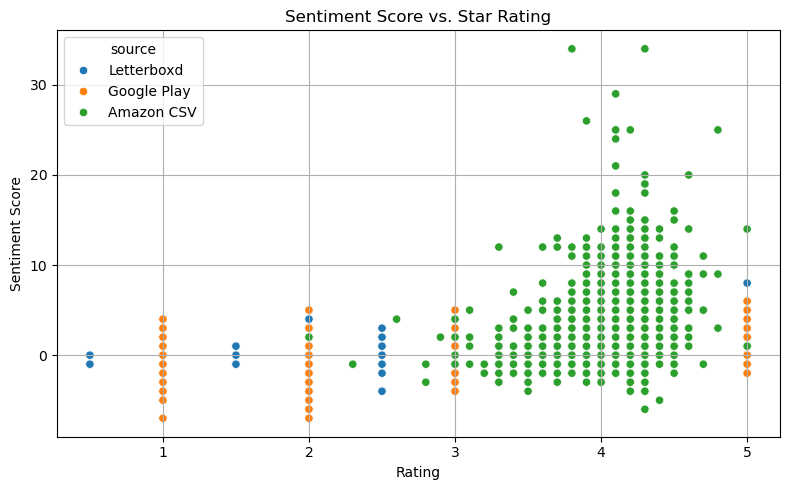

In [20]:
# Generate a scatterplot displaying the relationship between sentiment scores and star rating
def sentiment_vs_rating_scatterplot(df: pd.DataFrame) -> None:

    # Create scatterplot with rating on the x-axis and sentiment score on the y-axis, colored by source
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x="rating", y="sentiment_score", hue="source")
    plt.title("Sentiment Score vs. Star Rating")
    plt.xlabel("Rating")
    plt.ylabel("Sentiment Score")
    
    # Add gridlines and adjust layout, saving as a PNG and displaying
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("sentiment_vs_rating.png", dpi=300)
    plt.show()

# Call scatterplot function and pass combined DataFrame
sentiment_vs_rating_scatterplot(combined_df)

### **Mismatch Rate Barplot:**

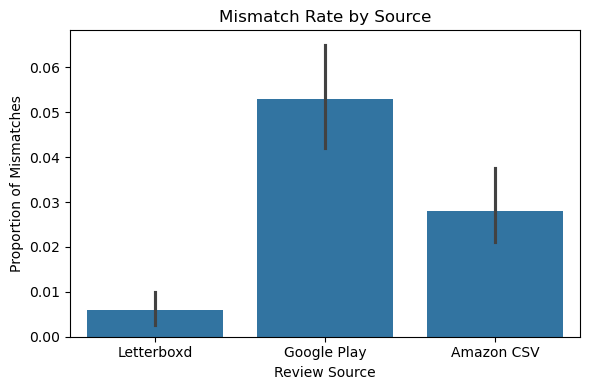

In [21]:
# Generate a barplot showing the mismatch rate across different review sources
def mismatch_rate_barplot(df: pd.DataFrame) -> None:
    
    # Create barplot with review source on x-axis and mismatch rate on y-axis
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x="source", y="mismatch")
    plt.title("Mismatch Rate by Source")
    plt.ylabel("Proportion of Mismatches")
    plt.xlabel("Review Source")

    # Adjust layout, save as PNG, and display
    plt.tight_layout()
    plt.savefig("mismatch_by_source.png", dpi=300)
    plt.show()

# Call barplot function and pass combined DataFrame
mismatch_rate_barplot(combined_df)

### **Sentiment Polarity Pie Chart:**

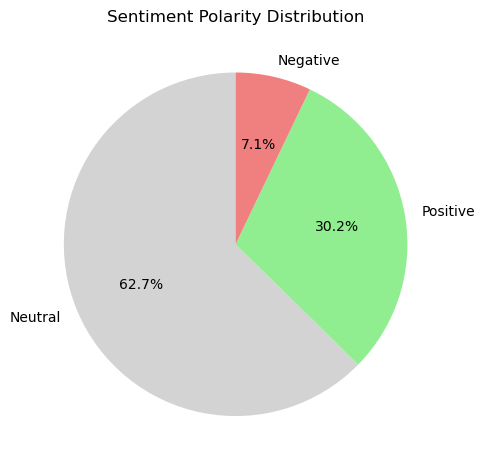

In [22]:
# Generate a pie chart showing the distribution of sentiment polarity categories
def sentiment_polarity_pie_chart(df: pd.DataFrame) -> None:

    # Create a pie chart of polarity classification counts with percentage labels
    plt.figure(figsize=(5,5))
    df["polarity"].value_counts().plot.pie(autopct="%.1f%%", startangle=90, colors=["lightgrey", "lightgreen", "lightcoral"])
    plt.title("Sentiment Polarity Distribution")
    plt.ylabel("")

    # Adjust layout, save as PNG, and display
    plt.tight_layout()
    plt.savefig("sentiment_polarity_distribution.png", dpi=300)
    plt.show()

# Call pie chart function and pass combined DataFrame
sentiment_polarity_pie_chart(combined_df)

### **Rating Distribution by Source Histogram:**

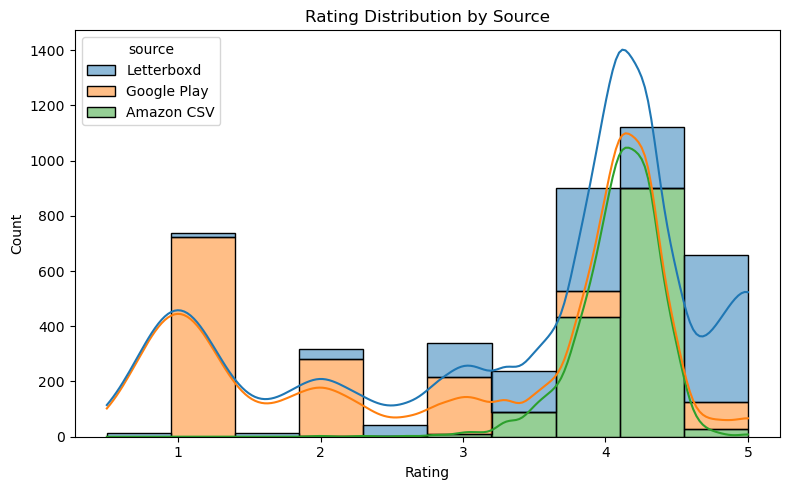

In [23]:
# Generate a histogram showing the distribution of ratings grouped by data source
def rating_distribution_by_source(df: pd.DataFrame) -> None:

    # Create histogram of ratings, colored by source, with KDE overlay
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x="rating", hue="source", kde=True, multiple="stack", bins=10)
    plt.title("Rating Distribution by Source")
    plt.xlabel("Rating")
    plt.ylabel("Count")

    # Adjust layout, save as PNG, and display
    plt.tight_layout()
    plt.savefig("rating_distribution_by_source.png", dpi=300)
    plt.show()

# Call histogram function and pass combined DataFrame
rating_distribution_by_source(combined_df)

### **Polarity by Rating Boxplot:**

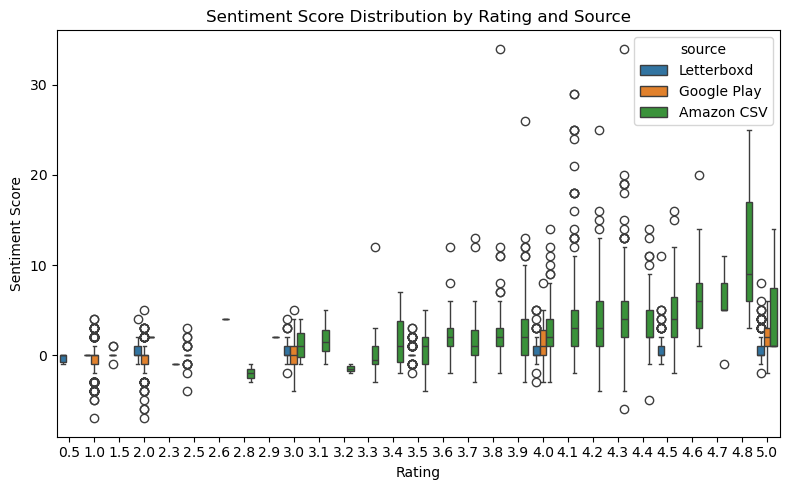

In [24]:
# Generate a boxplot to show how sentiment scores vary by rating and data source
def polarity_by_rating_boxplot(df: pd.DataFrame) -> None:

    # Create a boxplot with ratings on x-axis, sentiment scores on y-axis, grouped by source
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x="rating", y="sentiment_score", hue="source")
    plt.title("Sentiment Score Distribution by Rating and Source")
    plt.xlabel("Rating")
    plt.ylabel("Sentiment Score")

    # Adjust layout, save as PNG, and display
    plt.tight_layout()
    plt.savefig("polarity_by_rating_boxplot.png", dpi=300)
    plt.show()

# Call boxplot function and pass combined DataFrame
polarity_by_rating_boxplot(combined_df)

---
# **Section 12: Statistical Testing**

### **Chi-Square Test for Mismatch by Source:**

In [25]:
# Perform a Chi-Square test to assess whether mismatch rates differ significantly by source
def chi_square_mismatch_by_source(df: pd.DataFrame) -> None:

    print("Chi-Square Test for Mismatch Rate by Source:")

    # Create a contingency table with rows = sources & columns = mismatch True/False counts
    contingency_table = pd.crosstab(df["source"], df["mismatch"])

    # Run Chi-Square test on the contingency table
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    
    print("Chi-Square Statistic:", chi2)
    print("p-value:", p)

    # Interpret results of testing with a 0.05 significance value
    if p < 0.05:
        print("Significant difference in mismatch rates between sources.")
    else:
        print("No significant difference in mismatch rates between sources.")

# Call Chi Square test function and pass combined DataFrame
chi_square_mismatch_by_source(combined_df)

Chi-Square Test for Mismatch Rate by Source:
Chi-Square Statistic: 58.378852925914615
p-value: 2.1047143263255518e-13
Significant difference in mismatch rates between sources.


### **ANOVA test for Sentiment Score Differences Between Sources:**

In [26]:
# Perform an ANOVA test to check if sentiment scores differ significantly across platforms
def anova_sentiment_by_source(df: pd.DataFrame) -> None:
    
    print("ANOVA: Sentiment Score Differences Between Sources")

    # Extract list of unique sources (Letterboxd, Google Play, Amazon)
    sources = df["source"].unique()

    # Create a list of sentiment score Series, grouped by source
    groups = [df[df["source"] == s]["sentiment_score"] for s in sources]

    # Perform one-way ANOVA test on sentiment score groups
    f_stat, p_val = f_oneway(*groups)
    
    print("F-statistic:", f_stat)
    print("p-value:", p_val)

    # Interpret results of testing with a 0.05 significance level
    if p_val < 0.05:
        print("Significant difference in sentiment scores between platforms.")
    else:
        print("No significant difference in sentiment scores between platforms.")

# Call ANOVA test function and pass combined DataFrame
anova_sentiment_by_source(combined_df)

ANOVA: Sentiment Score Differences Between Sources
F-statistic: 757.0615868221126
p-value: 4.076034688901958e-283
Significant difference in sentiment scores between platforms.


### **T-Testing for Sentiment Scores by Matched vs. Mismatched Reviews:**

In [27]:
# Perform an independent T-test to compare sentiment scores between mismatched and matched reviews
def ttest_sentiment_by_mismatch(df: pd.DataFrame) -> None:
    
    print("T-Test: Sentiment Scores for Mismatched vs. Matched Reviews")

    # Extract sentiment scores for mismatched reviews
    mismatch_scores = df[df["mismatch"] == True]["sentiment_score"]

    # Extract sentiment scores for matched reviews
    match_scores = df[df["mismatch"] == False]["sentiment_score"]

    # Perform t-test, assuming unequal variance
    t_stat, p_val = ttest_ind(mismatch_scores, match_scores, equal_var=False)

    
    print("T-statistic:", t_stat)
    print("p-value:", p_val)

    # Interpret results of testing with a 0.05 significance level
    if p_val < 0.05:
        print("Sentiment scores significantly differ between mismatched and matched reviews.")
    else:
        print("No significant difference in sentiment scores between groups.")

# Call T-test function and pass combined DataFrame
ttest_sentiment_by_mismatch(combined_df)

T-Test: Sentiment Scores for Mismatched vs. Matched Reviews
T-statistic: -4.204133880140529
p-value: 4.767851390894303e-05
Sentiment scores significantly differ between mismatched and matched reviews.


### **Correlation Between Review Sentiment & Rating Number:**

In [28]:
# Compute and interpret the Pearson correlation between sentiment score and rating
def correlation_sentiment_rating(df: pd.DataFrame) -> None:
    
    print("Correlation: Sentiment Score vs. Rating")

    # Calculate Pearson correlation coefficient
    corr = df["sentiment_score"].corr(df["rating"])
    print(f"Pearson correlation: {corr:.3f}")

    # Interpret correlation strength given absolute value of correlation coefficient
    if abs(corr) >= 0.5:
        print("Strong correlation between sentiment and rating.")
    elif abs(corr) >= 0.3:
        print("Moderate correlation between sentiment and rating.")
    else:
        print("Weak correlation between sentiment and rating.")

# Call correlation function and pass combined DataFrame
correlation_sentiment_rating(combined_df)

Correlation: Sentiment Score vs. Rating
Pearson correlation: 0.320
Moderate correlation between sentiment and rating.


---
# **Section 13: Insights & Conclusions**

- The total misalignment rate of star ratings and review sentiment is around **2.83%**.
- The **Chi-Square test** identified **significant differences** in rates of mismatch by platform.
- The **ANOVA test identified that average sentiment ratings **significantly differ** among sources.
- The **T-test** revealed that mismatched reviews have **stronger and more extreme** sentiment than matched ones.
- **Correlation** between sentiment and **rating was moderate**, implying **slight discrepancy**.

These results validate the theory that text sentiment and numerical ratings do not necessarily coincide and the level of disparity is different across different platforms.

---

# **Section 14: Potential Next Steps**

- Future iterations of this project could incorporate ML-based sentiment scoring (Vader, TextBlob, or transformers).
- It may also be worthwhile to explore reviewer bias or category-specific sentiment differences.
- API rate limits and page availability were handled carefully, but increasing the breadth of scraped data remains an opportunity.